Este colab fue desarrollado por Arnold Charry Armero.

# XGBoost (Clasificación)

XGBoost (Extreme Gradient Boosting) es una implementación avanzada del algoritmo de Gradient Boosting que combina la idea de entrenar modelos débiles de manera secuencial con mejoras en eficiencia y capacidad de generalización. Al igual que en el boosting clásico, cada nuevo árbol se ajusta para corregir los errores de los modelos anteriores mediante el uso de gradientes, siguiendo un esquema de descenso de gradiente funcional. La principal diferencia con respecto al Gradient Boosting tradicional es que XGBoost incorpora una expansión de segundo orden de la función objetivo (utilizando gradientes y hessianos), lo que permite optimizar de forma más precisa. Además, añade términos de regularización que penalizan la complejidad de los árboles, evitando el sobreajuste y favoreciendo modelos más simples y robustos. Gracias a estas innovaciones, XGBoost logra entrenamientos más rápidos, mejor rendimiento en grandes volúmenes de datos y mayor precisión, convirtiéndose en una de las técnicas más populares y efectivas en la práctica del aprendizaje automático. Matemáticamente se define la función objetivo de la siguiente manera incluyendo regularización,

$$
\mathcal{L}(\phi) = \sum_{i=1}^{n} l(y_i, \hat{y}_i) + \sum_{k=1}^{K} \Omega(f_k)
$$

donde:
- $l(y_i, \hat{y}_i)$: función de pérdida.
- $f_k$: árbol de decisión en la iteración $k$\.
- $\Omega(f_k)$: término de regularización que controla la complejidad del modelo.

En el caso de clasificación, usando la función logística sigmoide (log-loss):

$$ \hat{p}_i = \sigma(\hat{y}_i) = \frac{1}{1 + e^{-\hat{y}_i}} $$

donde:
- $\hat{y}_i$ es la predicción cruda (logit) antes de aplicar la sigmoide.
- $\hat{p}_i$ es la probabilidad estimada de que $y_i = 1$.

La función de pérdida para un dato $(x_i, y_i)$ es:

$$ l(y_i, \hat{y}_i) = - \left[ y_i \log(\hat{p}_i) + (1 - y_i) \log(1 - \hat{p}_i) \right]$$

Ahora bien, la regularización en XGBoost es fundamental y se expresa como:

$$ \Omega(f) = \gamma T + \frac{1}{2}\lambda \sum_{j=1}^{T} w_j^2 $$

donde:
- $T$: número de hojas del árbol.
- $w_j$: peso asignado a la hoja $j$.
- $\gamma$: penalización por cada hoja adicional (controla profundidad).
- $\lambda$: penalización L2 sobre los pesos de las hojas.

Esto incentiva árboles más simples y evita el sobreajuste.

A diferencia del Gradient Boosting tradicional, XGBoost utiliza una aproximación de segundo orden de la función objetivo, lo que permite optimizar de manera más precisa:

$$
\mathcal{L}^{(t)} \simeq \sum_{i=1}^{n} \left[ g_i f_t(x_i) + \frac{1}{2} h_i f_t(x_i)^2 \right] + \Omega(f_t)
$$

donde:
- $ g_i = \frac{\partial l(y_i, \hat{y}_i^{(t-1)})}{\partial \hat{y}_i^{(t-1)}} $ (gradiente de primer orden).

- $ h_i = \frac{\partial^2 l(y_i, \hat{y}_i^{(t-1)})}{\partial (\hat{y}_i^{(t-1)})^2} $ (hessiano de segundo orden).
- $f_t(x)$: nuevo árbol añadido en la iteración $t$.

Cuando XGBoost construye un árbol, necesita decidir dónde dividir un nodo. Para ello, se calcula la ganancia de cada partición:

$$
\text{Gain} = \frac{1}{2} \left[ \frac{G_L^2}{H_L + \lambda} + \frac{G_R^2}{H_R + \lambda} - \frac{(G_L + G_R)^2}{H_L + H_R + \lambda} \right] - \gamma
$$

donde:
- $G_L, H_L$: suma de gradientes y hessianos de la izquierda.
- $G_R, H_R$: suma de gradientes y hessianos de la derecha.
- $\lambda, \gamma$: parámetros de regularización.

Si la ganancia es positiva, se realiza la división; si no, el nodo se convierte en una hoja.

XGBoost mejora al Gradient Boosting tradicional al:
1. Usar expansión de segundo orden (gradientes + hessianos).
2. Incorporar regularización explícita en la función objetivo.
3. Optimizar la construcción de árboles mediante la evaluación de la ganancia.

Ahora se continúa con la implementación en código,


In [ ]:
# Se importan las librerias
import math as mt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from pandas.api.types import is_numeric_dtype, is_object_dtype, is_string_dtype
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Machine Learning/Bases de Datos/diabetes.csv')

In [ ]:
df.head()

,Pregnancies,Glucose,Blood_Pressure,Skin_Thickness,Insulin,BMI,Diabetes_Pedigree_Function,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


Primero se analiza la base de datos,

In [ ]:
# Se verifica la cantidad de datos
df.shape

(768, 9)

Se puede observar que hay 768 filas. Se observará de qué tipo son estos valores y si hay faltantes.

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Pregnancies                 768 non-null    int64  
 1   Glucose                     768 non-null    int64  
 2   Blood_Pressure              768 non-null    int64  
 3   Skin_Thickness              768 non-null    int64  
 4   Insulin                     768 non-null    int64  
 5   BMI                         768 non-null    float64
 6   Diabetes_Pedigree_Function  768 non-null    float64
 7   Age                         768 non-null    int64  
 8   Outcome                     768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [ ]:
# Se verifica el tema de los faltantes
df.isnull().sum()[df.isnull().sum() != 0]

,0


Ahora se analizan las características con datos relevantes,

In [ ]:
df.describe()

,Pregnancies,Glucose,Blood_Pressure,Skin_Thickness,Insulin,BMI,Diabetes_Pedigree_Function,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


Se contabiliza la cantidad de personas con o sin diabetes,

In [ ]:
df['Outcome'].value_counts()

,count
Outcome,
0,500
1,268


## Preprocesamiento de Datos

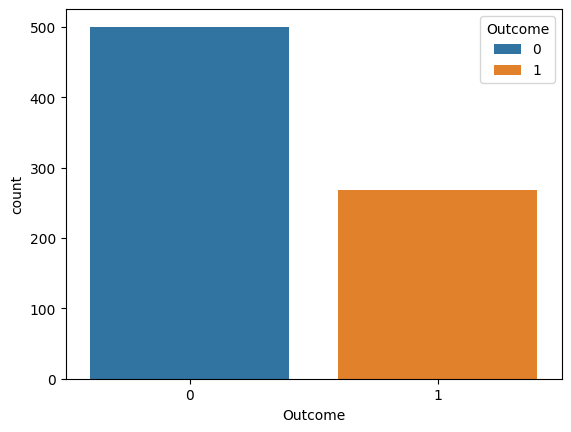

In [ ]:
# Gráfico de barras por cada clase
sns.countplot(data=df,x='Outcome', hue='Outcome')
plt.show()

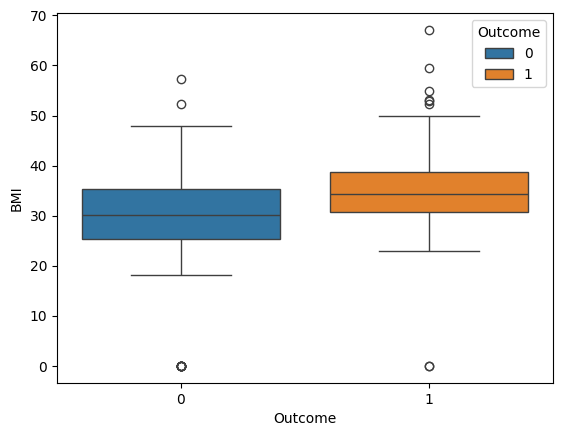

In [ ]:
# Gráfico de caja
sns.boxplot(x='Outcome',y='BMI',data=df, hue='Outcome')
plt.show()

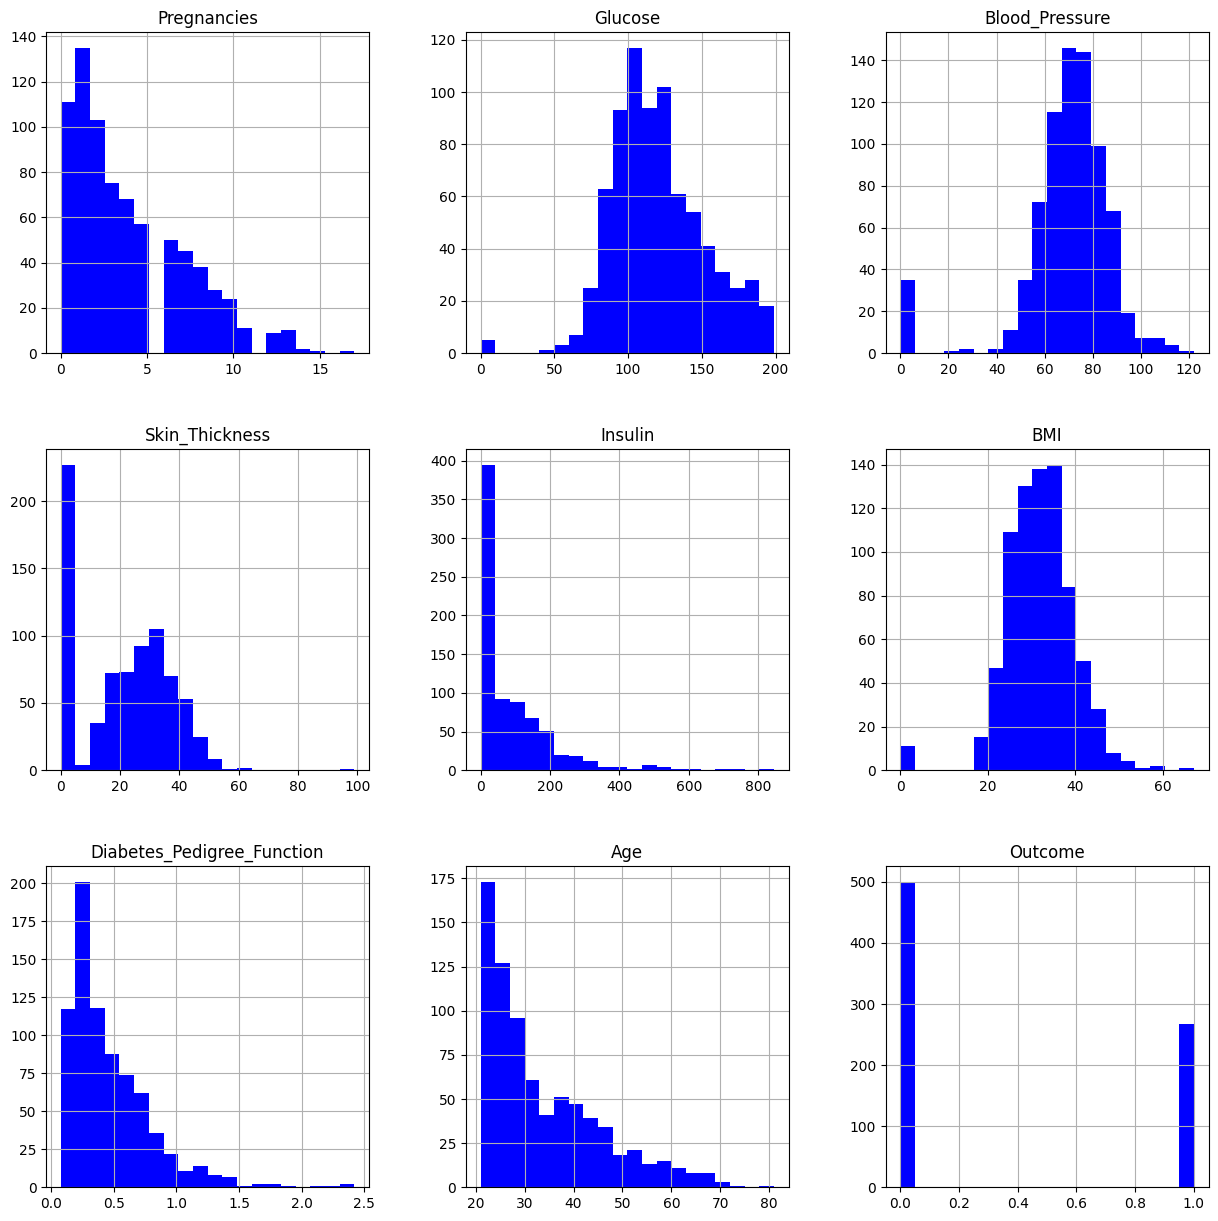

In [ ]:
df.hist(bins = 20, figsize = (15, 15), color = 'b')
plt.show()

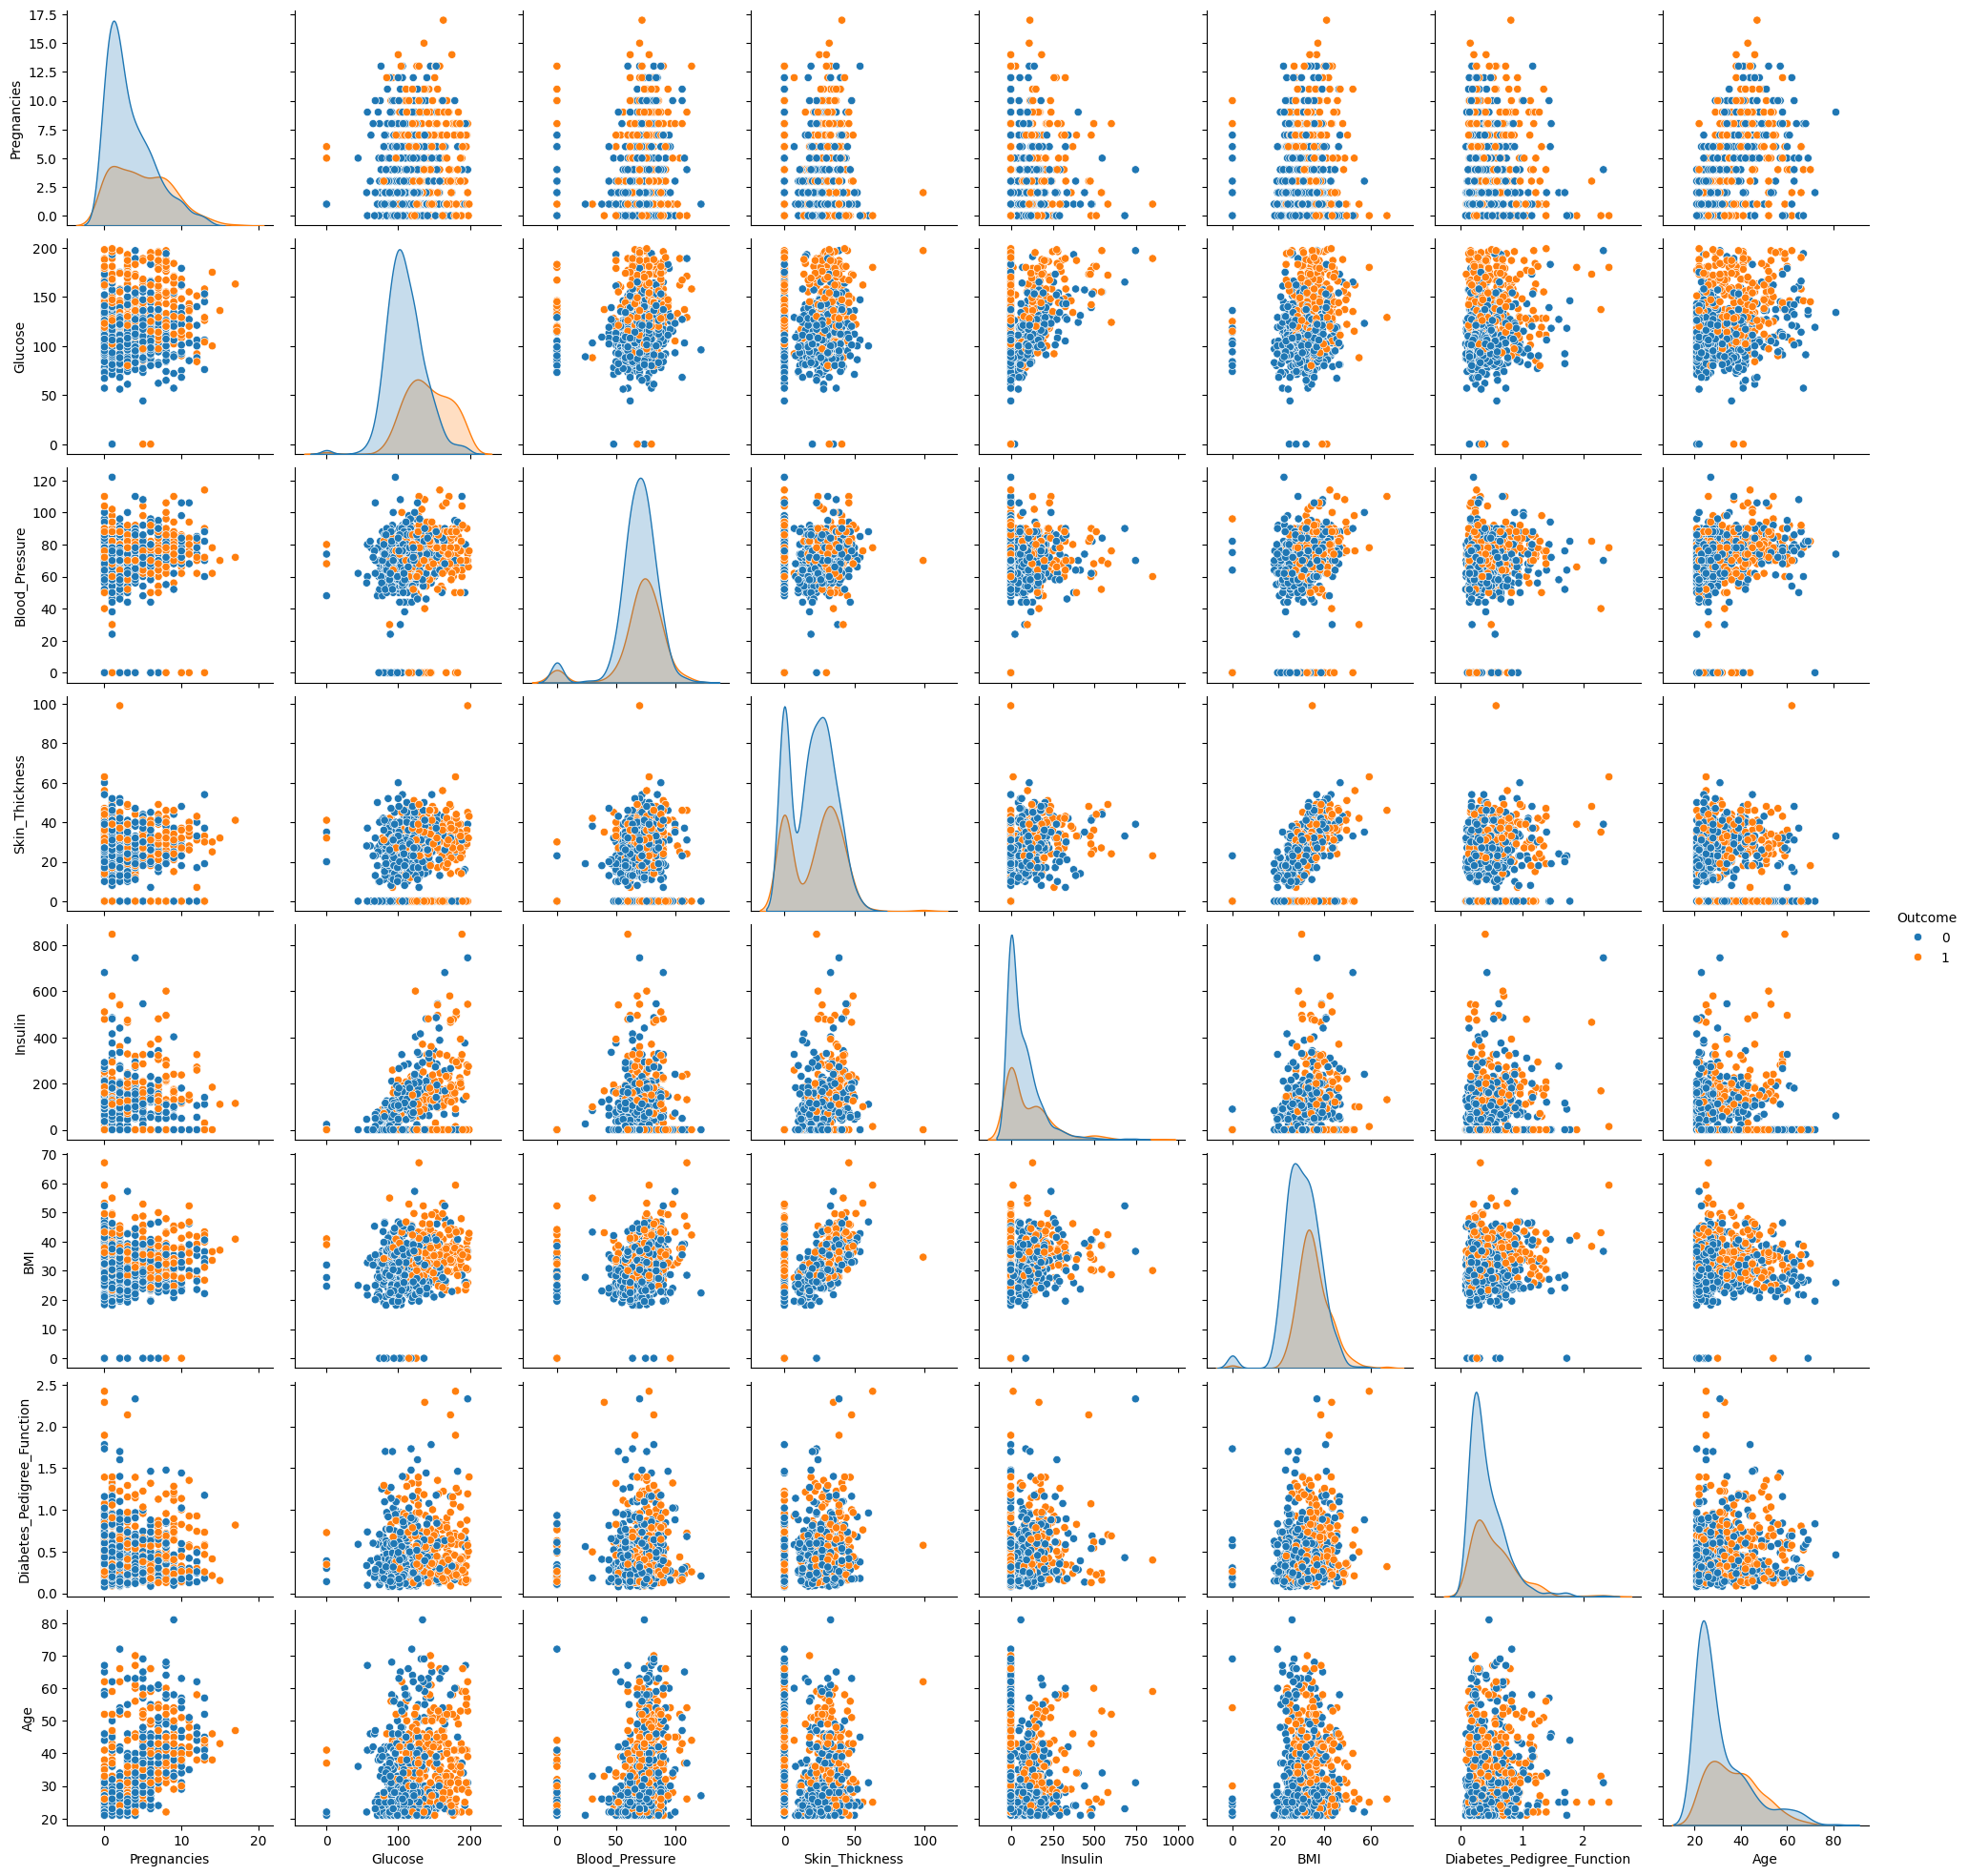

In [ ]:
sns.pairplot(df,hue='Outcome')
plt.show()

In [ ]:
# Obtenemos las características
X = df.iloc[:, :-1].values
y = df.iloc[:, -1].values

In [ ]:
# Se detectan las columnas categóricas
cat_cols = df.select_dtypes(include=['object', 'category']).columns
cat_indices = [df.columns.get_loc(col) for col in cat_cols]

# Se detectan las columnas numéricas
num_indices = [i for i in range(df.shape[1] - 1) if i not in cat_indices]

# Se crea el transformador
ct = ColumnTransformer(
    transformers=[('encoder', OneHotEncoder(drop='first',sparse_output=False, dtype=int), cat_indices)],
                    remainder='passthrough')

# Se aplica al array X
X = np.array(ct.fit_transform(X))

In [ ]:
# Visualizar el array X
print(X)

[[  6.    148.     72.    ...  33.6     0.627  50.   ]
 [  1.     85.     66.    ...  26.6     0.351  31.   ]
 [  8.    183.     64.    ...  23.3     0.672  32.   ]
 ...
 [  5.    121.     72.    ...  26.2     0.245  30.   ]
 [  1.    126.     60.    ...  30.1     0.349  47.   ]
 [  1.     93.     70.    ...  30.4     0.315  23.   ]]


## Separación en Base de datos de Entrenamiento y Prueba

In [ ]:
# Se divide la base de datos
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

## Entrenamiento del Modelo

Ahora vamos con el modelo XGBoost para clasificación,

In [ ]:
XGB_model = XGBClassifier(n_estimators = 200, learning_rate = 0.1, random_state = 42)
XGB_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=200,
              n_jobs=None, num_parallel_tree=None, ...)

Realizando una predicción,

In [ ]:
# Se debe de hacer en el orden original
print("Predicción:", XGB_model.predict(ct.transform([[6, 148, 72, 29,	0, 26.6, 0.351, 31]]))[0])

Predicción: 1


In [ ]:
# Obtenemos las predicciones
y_pred = XGB_model.predict(X_test)
print(y_pred.reshape(len(y_pred),1))

[[1]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [1]
 [0]
 [1]
 [0]
 [1]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [1]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [0]
 [0]
 [1]
 [0]
 [0]
 [1]
 [0]
 [0]
 [1]
 [1]
 [0]
 [0]
 [1]
 [0]
 [1]
 [1]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [1]
 [1]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [1]
 [0]
 [1]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [1]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [1]
 [1]
 [1]
 [0]
 [1]
 [0]
 [1]
 [0]
 [1]
 [1]
 [1]
 [0]
 [0]
 [1]
 [0]
 [1]
 [0]
 [1]
 [0]
 [1]
 [1]
 [1]
 [1]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [1]
 [1]
 [1]
 [1]
 [0]
 [0]
 [1]
 [0]
 [0]
 [1]
 [1]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [1]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [1]
 [1]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [1]
 [1]
 [1]
 [0]
 [1]
 [1]
 [1]
 [0]
 [1]
 [1]
 [1]
 [1]
 [0]
 [0]
 [1]
 [1]
 [1]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]


## Rendimiento del Modelo

In [ ]:
# Obteniendo la precisión del modelo
print('Accuracy:', accuracy_score(y_test, y_pred))

Accuracy: 0.7402597402597403


In [ ]:
# Matriz de confusión
confusion_matrix(y_test,y_pred)

array([[116,  35],
       [ 25,  55]])

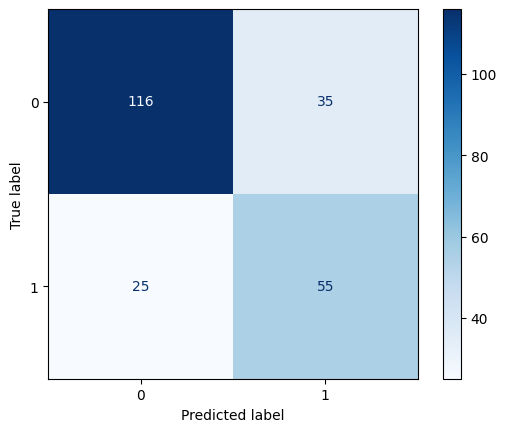

In [ ]:
# Visualizando la matriz de confusión
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels = [0, 1])
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.show()

In [ ]:
# Obteniendo el reporte de clasificación
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.82      0.77      0.79       151
           1       0.61      0.69      0.65        80

    accuracy                           0.74       231
   macro avg       0.72      0.73      0.72       231
weighted avg       0.75      0.74      0.74       231



## Validación Cruzada y Grid Search

In [ ]:
# Aplicar K-fold Cross Validation
accuracies = cross_val_score(estimator = XGB_model, X = X_train, y = y_train, cv = 10, scoring = 'accuracy')
print(accuracies.mean())

0.7374213836477987


Se conocen los parámetros de XGBoost para evaluar el GridSearch.


In [ ]:
XGB_model = XGBClassifier(n_estimators = 200, random_state = 42)
XGB_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=200,
              n_jobs=None, num_parallel_tree=None, ...)

In [ ]:
# Parámetros
XGB_model.get_params().keys()

dict_keys(['objective', 'base_score', 'booster', 'callbacks', 'colsample_bylevel', 'colsample_bynode', 'colsample_bytree', 'device', 'early_stopping_rounds', 'enable_categorical', 'eval_metric', 'feature_types', 'feature_weights', 'gamma', 'grow_policy', 'importance_type', 'interaction_constraints', 'learning_rate', 'max_bin', 'max_cat_threshold', 'max_cat_to_onehot', 'max_delta_step', 'max_depth', 'max_leaves', 'min_child_weight', 'missing', 'monotone_constraints', 'multi_strategy', 'n_estimators', 'n_jobs', 'num_parallel_tree', 'random_state', 'reg_alpha', 'reg_lambda', 'sampling_method', 'scale_pos_weight', 'subsample', 'tree_method', 'validate_parameters', 'verbosity'])

In [ ]:
# Se establecen los parámetros a probar
parameters = {
    "n_estimators": [50, 100, 200],
    "learning_rate": [0.05, 0.1, 0.2],
    "max_depth": [3, 4, 5],
    "subsample": [0.8, 1],
    "colsample_bytree": [0.8, 1]}

In [ ]:
# Se utiliza GridSearchCV
full_cv_classifier = GridSearchCV(estimator = XGB_model,
                                  param_grid = parameters,
                                  cv = 10,
                                  scoring = 'accuracy',
                                  n_jobs = -1,
                                  verbose = 2)

In [ ]:
# Se entrena el CV_Classifier
full_cv_classifier.fit(X_train, y_train)

Fitting 10 folds for each of 108 candidates, totalling 1080 fits


GridSearchCV(cv=10,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, feature_weights=None,
                                     gamma=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=No...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=200,
                                     n_jobs=None, num_parallel_tree=None, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.8, 1],
                         'learning_rate': [0.05, 0.1, 0.2],
                         'max_depth': [3, 4, 5], 'n_estimators': [50, 100, 200],
                         'subsample': [0.8, 1]},
             scoring='accuracy', verbose=2)

In [ ]:
print(full_cv_classifier.best_params_)

{'colsample_bytree': 1, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 50, 'subsample': 1}


In [ ]:
# Se obtiene el mejor resultado
print(full_cv_classifier.best_score_)

0.7764150943396226


Ahora se vuelve a entrenar el modelo, pero con los parámetros óptimos.

In [ ]:
model = XGBClassifier(n_estimators = 50, learning_rate = 0.1, max_depth = 5, random_state = 42, colsample_bytree = 1)
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None, colsample_bytree=1,
              device=None, early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, feature_weights=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=50, n_jobs=None,
              num_parallel_tree=None, ...)

In [ ]:
# Obtenemos las predicciones
y_pred = model.predict(X_test)
print(y_pred.reshape(len(y_pred),1))

[[1]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [1]
 [0]
 [1]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [1]
 [0]
 [0]
 [0]
 [0]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [0]
 [0]
 [1]
 [0]
 [0]
 [1]
 [1]
 [0]
 [1]
 [1]
 [0]
 [0]
 [1]
 [0]
 [1]
 [1]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [1]
 [0]
 [1]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [1]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [1]
 [1]
 [1]
 [0]
 [1]
 [0]
 [1]
 [0]
 [1]
 [1]
 [1]
 [0]
 [0]
 [1]
 [0]
 [1]
 [0]
 [1]
 [0]
 [1]
 [0]
 [1]
 [1]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [1]
 [1]
 [1]
 [1]
 [1]
 [0]
 [0]
 [1]
 [0]
 [0]
 [1]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [1]
 [1]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [1]
 [1]
 [1]
 [0]
 [1]
 [0]
 [1]
 [0]
 [1]
 [1]
 [1]
 [1]
 [0]
 [0]
 [0]
 [1]
 [1]
 [0]
 [0]
 [0]
 [1]
 [1]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]


In [ ]:
# Obteniendo la precisión del modelo
print('Accuracy:', accuracy_score(y_test, y_pred))

Accuracy: 0.7316017316017316


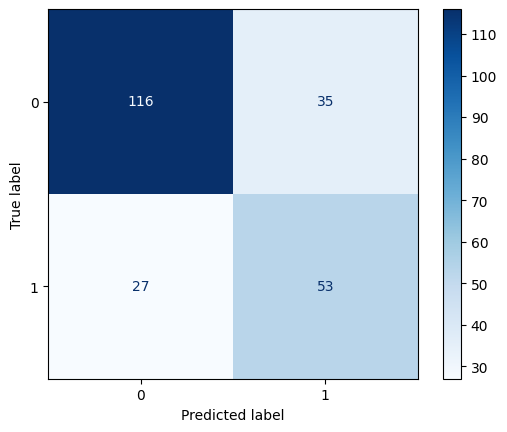

In [ ]:
# Visualizando la matriz de confusión
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels = [0, 1])
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.show()

In [ ]:
# Obteniendo el reporte de clasificación
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.81      0.77      0.79       151
           1       0.60      0.66      0.63        80

    accuracy                           0.73       231
   macro avg       0.71      0.72      0.71       231
weighted avg       0.74      0.73      0.73       231



Obteniendo las características más importantes,

In [ ]:
features = model.feature_importances_

In [ ]:
feats = pd.DataFrame(index = df.columns[:-1], data = features, columns = ["Importance"])

In [ ]:
display(feats)

,Importance
Pregnancies,0.098518
Glucose,0.300009
Blood_Pressure,0.071516
Skin_Thickness,0.063757
Insulin,0.103820
BMI,0.147640
Diabetes_Pedigree_Function,0.075077
Age,0.139663


Se imprime un gráfico con las características más importantes,

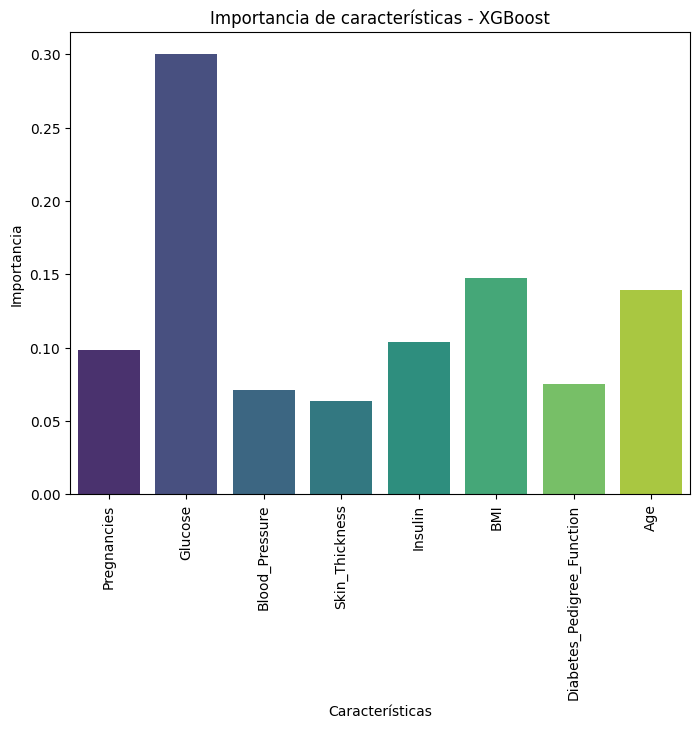

In [ ]:
plt.figure(figsize = (8, 6))
sns.barplot(data = feats, x = feats.index, y = 'Importance', hue = feats.index, palette="viridis")
plt.xticks(rotation=90)
plt.xlabel("Características")
plt.ylabel("Importancia")
plt.title("Importancia de características - XGBoost")
plt.show()

## Referencias

*   Diabetes Prediction Dataset. (2022, December 27). Kaggle. https://www.kaggle.com/datasets/fhabibimoghaddam/diabetes-prediction
*   GeeksforGeeks. (2025, September 5). XGBoost. GeeksforGeeks. https://www.geeksforgeeks.org/machine-learning/xgboost/
*   Introduction to Boosted Trees — xgboost 3.0.5 documentation. (n.d.). https://xgboost.readthedocs.io/en/stable/tutorials/model.html
*   Leventis, D. (2022, January 2). XGBoost Mathematics Explained. Medium. https://dimleve.medium.com/xgboost-mathematics-explained-58262530904a
*   Vandeput, N. (2021). Data science for supply chain forecasting. de Gruyter.
